Caricamento e preprocessing dei dati

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

#file_path = "../../data/processed/wifi_fingerprinting_dataset.csv"
#file_path = "../../data/processed/wifi_fingerprinting_dataset_cut_200_ap27.csv"
file_path = "../../data/processed/wifi_fingerprinting_dataset_cut_400_ap22.csv"

df = pd.read_csv(file_path, sep=',')

# NaN values are replaced with -100
df.fillna(-100, inplace=True)

df_empty = df[df["Situazione"] == "Empty"].drop(columns=["Situazione"])
df_crowded = df[df["Situazione"] == "Crowded"].drop(columns=["Situazione"])

# Function to split data
def split_data(df):
    X = df.drop(columns=["Aula"])
    y = df["Aula"]
    # 70% training, 15% validation, 15% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train_empty, X_val_empty, X_test_empty, y_train_empty, y_val_empty, y_test_empty = split_data(df_empty)
X_train_crowded, X_val_crowded, X_test_crowded, y_train_crowded, y_val_crowded, y_test_crowded = split_data(df_crowded)

print(f"Empty -> Training: {X_train_empty.shape}, Validation: {X_val_empty.shape}, Test: {X_test_empty.shape}")
print(f"Crowded -> Training: {X_train_crowded.shape}, Validation: {X_val_crowded.shape}, Test: {X_test_crowded.shape}")

Empty -> Training: (338, 22), Validation: (73, 22), Test: (73, 22)
Crowded -> Training: (349, 22), Validation: (75, 22), Test: (75, 22)


Addestramento del modello con knn

In [2]:
from sklearn.neighbors import KNeighborsClassifier

model_empty = KNeighborsClassifier(n_neighbors=5)
model_empty.fit(X_train_empty, y_train_empty)

model_crowded = KNeighborsClassifier(n_neighbors=5)
model_crowded.fit(X_train_crowded, y_train_crowded)

KNeighborsClassifier()

Risultati con dati completi

In [3]:
from sklearn.metrics import classification_report

# Validation Set
y_val_pred_empty = model_empty.predict(X_val_empty)
y_val_pred_crowded = model_crowded.predict(X_val_crowded)

print("Prestazioni su dati empty (Validation Set):")
print(classification_report(y_val_empty, y_val_pred_empty))

print("\nPrestazioni su dati crowded (Validation Set):")
print(classification_report(y_val_crowded, y_val_pred_crowded))

Prestazioni su dati empty (Validation Set):
              precision    recall  f1-score   support

    Corridor       0.93      1.00      0.97        14
          E1       1.00      1.00      1.00        15
          E2       1.00      0.93      0.97        15
          E3       1.00      1.00      1.00         8
      Garden       1.00      1.00      1.00        21

    accuracy                           0.99        73
   macro avg       0.99      0.99      0.99        73
weighted avg       0.99      0.99      0.99        73


Prestazioni su dati crowded (Validation Set):
              precision    recall  f1-score   support

    Corridor       1.00      1.00      1.00        15
          E1       1.00      1.00      1.00        16
          E2       1.00      1.00      1.00        16
          E3       1.00      1.00      1.00         8
      Garden       1.00      1.00      1.00        20

    accuracy                           1.00        75
   macro avg       1.00      1.00      1

In [4]:
# Test Set
y_pred_empty = model_empty.predict(X_test_empty)
y_pred_crowded = model_crowded.predict(X_test_crowded)

print("Prestazioni su dati empty (Test Set):")
print(classification_report(y_test_empty, y_pred_empty))
print("\nPrestazioni su dati crowded (Test Set):")
print(classification_report(y_test_crowded, y_pred_crowded))

Prestazioni su dati empty (Test Set):
              precision    recall  f1-score   support

    Corridor       1.00      1.00      1.00        15
          E1       1.00      1.00      1.00        15
          E2       1.00      1.00      1.00        15
          E3       1.00      1.00      1.00         7
      Garden       1.00      1.00      1.00        21

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73


Prestazioni su dati crowded (Test Set):
              precision    recall  f1-score   support

    Corridor       1.00      1.00      1.00        15
          E1       1.00      1.00      1.00        16
          E2       1.00      1.00      1.00        17
          E3       1.00      1.00      1.00         7
      Garden       1.00      1.00      1.00        20

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        7

Simulazione della perdita di dati

In [5]:
import numpy as np

# Simulate 30% missing values
def simulate_missing_values(X, missing_rate=0.3, missing_value=-100):
    X_missing = X.copy()
    mask = np.random.rand(*X_missing.shape) < missing_rate
    X_missing[mask] = missing_value
    return X_missing

X_test_empty_missing = simulate_missing_values(X_test_empty, missing_rate=0.3)
X_test_crowded_missing = simulate_missing_values(X_test_crowded, missing_rate=0.3)

y_pred_empty_missing = model_empty.predict(X_test_empty_missing)
y_pred_crowded_missing = model_crowded.predict(X_test_crowded_missing)

print("Prestazioni su dati empty con perdita di dati:")
print(classification_report(y_test_empty, y_pred_empty_missing))
print("\nPrestazioni su dati crowded con perdita di dati:")
print(classification_report(y_test_crowded, y_pred_crowded_missing))

Prestazioni su dati empty con perdita di dati:
              precision    recall  f1-score   support

    Corridor       0.62      0.87      0.72        15
          E1       1.00      0.47      0.64        15
          E2       1.00      0.80      0.89        15
          E3       1.00      0.71      0.83         7
      Garden       0.75      1.00      0.86        21

    accuracy                           0.79        73
   macro avg       0.87      0.77      0.79        73
weighted avg       0.85      0.79      0.79        73


Prestazioni su dati crowded con perdita di dati:
              precision    recall  f1-score   support

    Corridor       0.46      0.73      0.56        15
          E1       1.00      0.44      0.61        16
          E2       1.00      0.76      0.87        17
          E3       0.80      0.57      0.67         7
      Garden       0.77      1.00      0.87        20

    accuracy                           0.73        75
   macro avg       0.81      0.70 

Visualizzazione dei risultati

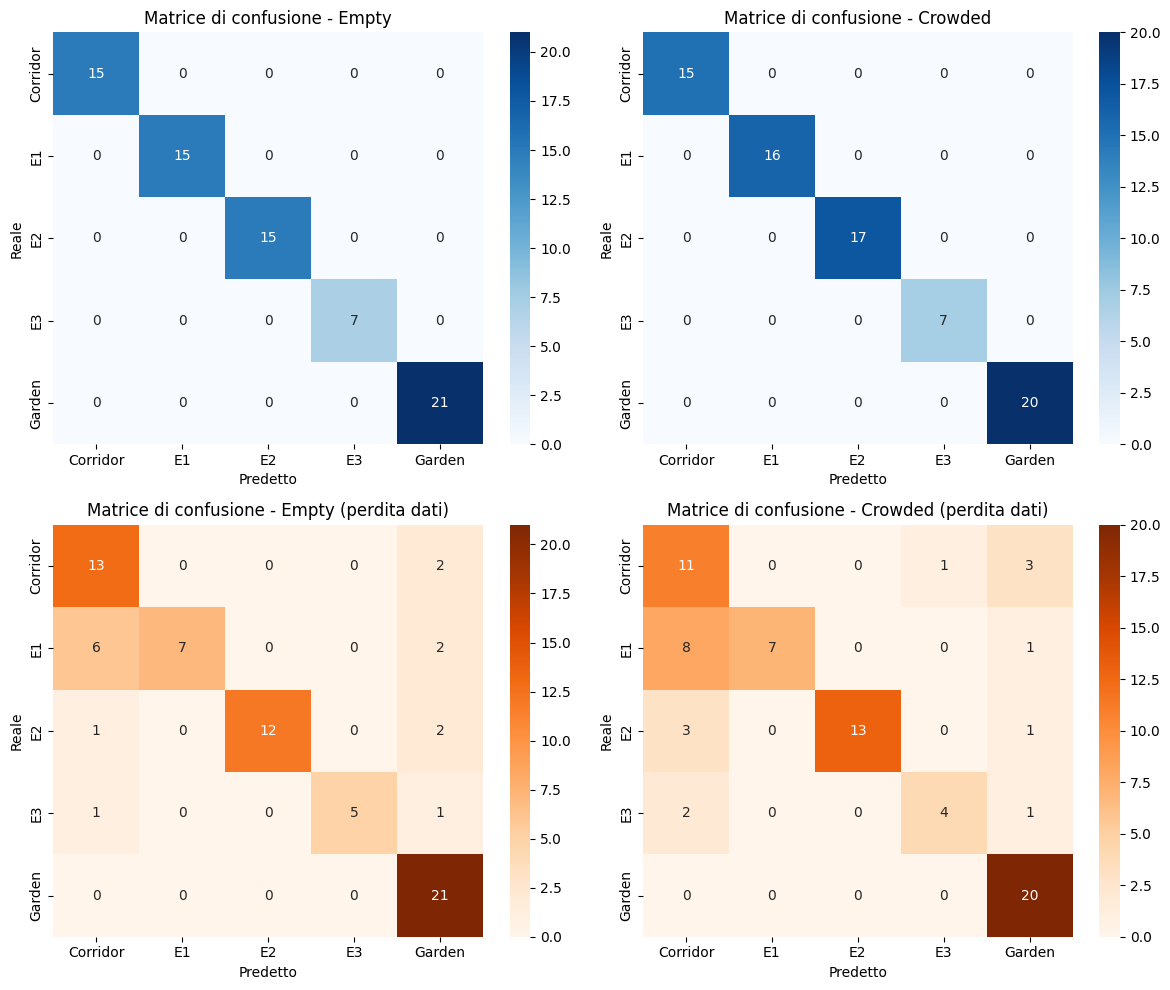

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_labels_empty = sorted(y_test_empty.unique())
class_labels_crowded = sorted(y_test_crowded.unique())

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.heatmap(confusion_matrix(y_test_empty, y_pred_empty), annot=True, fmt="d", cmap="Blues", ax=axes[0, 0], 
            xticklabels=class_labels_empty, yticklabels=class_labels_empty)
axes[0, 0].set_title("Matrice di confusione - Empty")
axes[0, 0].set_xlabel("Predetto")
axes[0, 0].set_ylabel("Reale")

sns.heatmap(confusion_matrix(y_test_crowded, y_pred_crowded), annot=True, fmt="d", cmap="Blues", ax=axes[0, 1],
            xticklabels=class_labels_crowded, yticklabels=class_labels_crowded)
axes[0, 1].set_title("Matrice di confusione - Crowded")
axes[0, 1].set_xlabel("Predetto")
axes[0, 1].set_ylabel("Reale")

sns.heatmap(confusion_matrix(y_test_empty, y_pred_empty_missing), annot=True, fmt="d", cmap="Oranges", ax=axes[1, 0],
            xticklabels=class_labels_empty, yticklabels=class_labels_empty)
axes[1, 0].set_title("Matrice di confusione - Empty (perdita dati)")
axes[1, 0].set_xlabel("Predetto")
axes[1, 0].set_ylabel("Reale")

sns.heatmap(confusion_matrix(y_test_crowded, y_pred_crowded_missing), annot=True, fmt="d", cmap="Oranges", ax=axes[1, 1],
            xticklabels=class_labels_crowded, yticklabels=class_labels_crowded)
axes[1, 1].set_title("Matrice di confusione - Crowded (perdita dati)")
axes[1, 1].set_xlabel("Predetto")
axes[1, 1].set_ylabel("Reale")

plt.tight_layout()

plt.show()